In [1]:
import pandas as pd

import matplotlib
from matplotlib import pyplot as plt

import numpy as np

from sklearn.metrics import ndcg_score

from scipy.stats import pearsonr, spearmanr

In [2]:
mapping_dict = {1:"mut",2:"cnv",3:"comb",4:"seg_cnv",5:"seg_comb"}
for i in range(1, 6):
    
    print(mapping_dict[i]+" data results:")
    # without sim
    results = pd.read_csv(f"Results_0308/Result_{i}/results_df_20_epochs_seed42.csv", delimiter='\t')
    results = results.drop_duplicates().reset_index(drop = True)
    results = results.iloc[results[["y_true","y_cell","y_drug"]].drop_duplicates().index].reset_index(drop = True)
    
    results_df = pd.DataFrame(columns = ['cell_line', 'true_auc_arr', 'pred_auc_arr'])
    results_df.cell_line = results.y_cell.unique()
    for i in range(results.shape[0]):
        y_true = results.iloc[i]['y_true']
        y_pred = results.iloc[i]['y_pred']
        cell_id = results.iloc[i]['y_cell']

        cell_index = np.where(results_df['cell_line'] == cell_id)[0][0]
        if type(results_df.iloc[cell_index]['true_auc_arr']) is not list:
            results_df.iloc[cell_index]['true_auc_arr'] = list()
        results_df.iloc[cell_index]['true_auc_arr'].append(y_true)
        if type(results_df.iloc[cell_index]['pred_auc_arr']) is not list:
            results_df.iloc[cell_index]['pred_auc_arr'] = list()
        results_df.iloc[cell_index]['pred_auc_arr'].append(y_pred)
        
    pred_values = results_df.pred_auc_arr.apply(lambda x: np.array(x)).to_numpy()
    true_values = results_df.true_auc_arr.apply(lambda x: np.array(x)).to_numpy()
    
    ### NDCG
    ndcg_all_values = []
    ndcg_10_values = []
    for i in range(len(pred_values)):
        pred_value = results_df['pred_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
        true_value = results_df['true_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
        if len(pred_value) == 1:
            continue
        ndcg_all_values.append(ndcg_score([pred_value,],[true_value,]))
        ndcg_10_values.append(ndcg_score([pred_value,],[true_value,], k = 10))

    ndcg_all = np.mean(ndcg_all_values)
    ndcg_10 = np.mean(ndcg_10_values)

    print(ndcg_all)
    print(ndcg_10)
    
    ### Recall
    results = []
    for top_k in [1, 2, 5, 10]:
        dict_test_cell_line_idx_perf = {}
        for cur_cell_line_idx in range(len(pred_values)):
            # step 1
            # per the ground truth
            gt_ic50s = true_values[cur_cell_line_idx]
            # find the top k drugs's idx
            topk_drug_idx_gt = np.argsort(gt_ic50s)[:top_k]
            # step 2
            # per the predicted scores
            pred_scores = pred_values[cur_cell_line_idx]
            assert gt_ic50s.shape == pred_scores.shape
            # find the top k drugs'idx (note: here its by pred scores)
            topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
            # step 3
            # recall@k
            cur_recall_at_k = len(
                set(topk_drug_idx_pred).intersection(set(topk_drug_idx_gt))
            ) / len(set(topk_drug_idx_gt))
            dict_test_cell_line_idx_perf[cur_cell_line_idx] = cur_recall_at_k

        avg_recall_at_k = np.mean(list(dict_test_cell_line_idx_perf.values()))
        results.append((f"Recall@{top_k}", round(avg_recall_at_k, 4)))
    print(results)
    
    ### AUC
    results = []
    for top_k in [1, 2, 5, 10]:
        dict_test_cell_line_topk_ic50_sum_gt = {}
        dict_test_cell_line_topk_ic50_sum_pred = {}
        for cur_cell_line_idx in range(len(pred_values)):
            # step 1
            # per the predicted scores
            pred_scores = pred_values[cur_cell_line_idx]
            # find the top k drugs'idx (note: here its by pred scores)
            topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
            # step 2
            # per the ground truth
            gt_ic50s = true_values[cur_cell_line_idx]
            # find the top k predicted drugs' (per ground truth) ic50s
            topk_drug_idx_gt = np.argsort(gt_ic50s)[:top_k]
            dict_test_cell_line_topk_ic50_sum_gt[cur_cell_line_idx] = np.mean(
                gt_ic50s[topk_drug_idx_gt]
            )
            dict_test_cell_line_topk_ic50_sum_pred[cur_cell_line_idx] = np.mean(
                gt_ic50s[topk_drug_idx_pred]
            )

        avg_ic50_topk_gt = np.mean(
            list(dict_test_cell_line_topk_ic50_sum_gt.values())
        )
        avg_ic50_topk_pred = np.mean(
            list(dict_test_cell_line_topk_ic50_sum_pred.values())
        )

        results.append(
            (
                f"Auc@{top_k}",
                f"{round(avg_ic50_topk_pred, 4)} (GT: {round(avg_ic50_topk_gt, 4)})",
            )
        )

    print(results)
    
    print("-------------------------------------------------")

mut data results:
0.9367739195881039
0.8001112034677282
[('Recall@1', 0.3768), ('Recall@2', 0.3768), ('Recall@5', 0.4406), ('Recall@10', 0.4522)]
[('Auc@1', '0.2395 (GT: 0.1198)'), ('Auc@2', '0.3141 (GT: 0.157)'), ('Auc@5', '0.3692 (GT: 0.222)'), ('Auc@10', '0.4259 (GT: 0.2893)')]
-------------------------------------------------
cnv data results:
0.9376738246399828
0.8066279600146181
[('Recall@1', 0.3768), ('Recall@2', 0.3768), ('Recall@5', 0.458), ('Recall@10', 0.4652)]
[('Auc@1', '0.2463 (GT: 0.1198)'), ('Auc@2', '0.3167 (GT: 0.157)'), ('Auc@5', '0.3632 (GT: 0.222)'), ('Auc@10', '0.4271 (GT: 0.2893)')]
-------------------------------------------------
comb data results:
0.9393631516640402
0.8048144123806908
[('Recall@1', 0.3768), ('Recall@2', 0.3913), ('Recall@5', 0.4435), ('Recall@10', 0.4594)]
[('Auc@1', '0.2447 (GT: 0.1198)'), ('Auc@2', '0.3157 (GT: 0.157)'), ('Auc@5', '0.3699 (GT: 0.222)'), ('Auc@10', '0.4273 (GT: 0.2893)')]
-------------------------------------------------
seg_

mut data results:
0.7220150469658773 0.7218091299363991


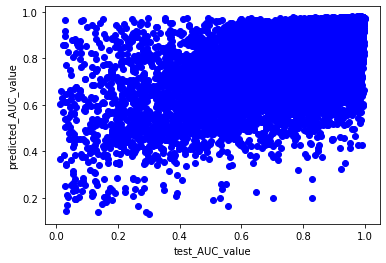

cnv data results:
0.7605036220196429 0.742699013689196


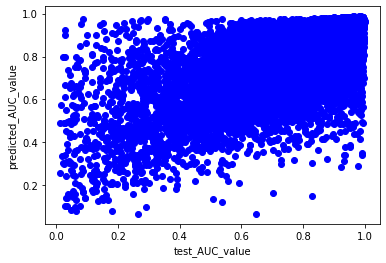

comb data results:
0.7464935421595558 0.7304603679736402


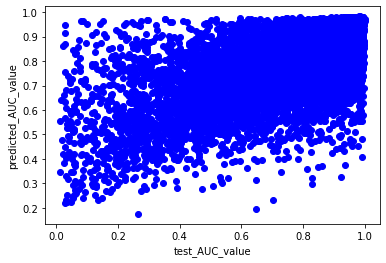

seg_cnv data results:
0.7576692695434888 0.7332288283433791


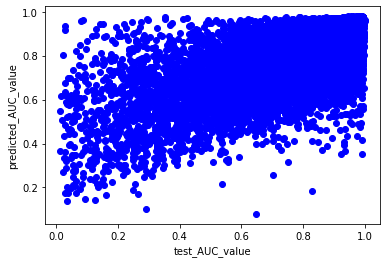

seg_comb data results:
0.7558659937013752 0.738895596410336


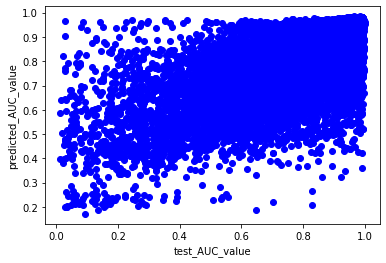

In [3]:
mapping_dict = {1:"mut",2:"cnv",3:"comb",4:"seg_cnv",5:"seg_comb"}
for i in range(1, 6):
    
    print(mapping_dict[i]+" data results:")
    # without sim
    results = pd.read_csv(f"Results_0308/Result_{i}/results_df_20_epochs_seed42.csv", delimiter='\t')
    results = results.drop_duplicates().reset_index(drop = True)
    results = results.iloc[results[["y_true","y_cell","y_drug"]].drop_duplicates().index].reset_index(drop = True)
    print(pearsonr(results.y_true, results.y_pred)[0], spearmanr(results.y_true, results.y_pred)[0])

    plt.figure()
    plt.scatter(results.y_true,results.y_pred,c='blue')
    plt.xlabel('test_AUC_value')
    plt.ylabel('predicted_AUC_value')
    plt.show()

In [4]:
mapping_dict = {1:"mut",2:"cnv",3:"comb",4:"seg_cnv",5:"seg_comb"}
for i in range(1, 6):
    
    print(mapping_dict[i]+" data results:")
    # with sim
    results = pd.read_csv(f"Results_0308/Result_{i}/results_sim_df_20_epochs_seed42.csv", delimiter='\t')
    results = results.drop_duplicates().reset_index(drop = True)
    results = results.iloc[results[["y_true","y_cell","y_drug"]].drop_duplicates().index].reset_index(drop = True)
    
    results_df = pd.DataFrame(columns = ['cell_line', 'true_auc_arr', 'pred_auc_arr'])
    results_df.cell_line = results.y_cell.unique()
    for i in range(results.shape[0]):
        y_true = results.iloc[i]['y_true']
        y_pred = results.iloc[i]['y_pred']
        cell_id = results.iloc[i]['y_cell']

        cell_index = np.where(results_df['cell_line'] == cell_id)[0][0]
        if type(results_df.iloc[cell_index]['true_auc_arr']) is not list:
            results_df.iloc[cell_index]['true_auc_arr'] = list()
        results_df.iloc[cell_index]['true_auc_arr'].append(y_true)
        if type(results_df.iloc[cell_index]['pred_auc_arr']) is not list:
            results_df.iloc[cell_index]['pred_auc_arr'] = list()
        results_df.iloc[cell_index]['pred_auc_arr'].append(y_pred)
        
    pred_values = results_df.pred_auc_arr.apply(lambda x: np.array(x)).to_numpy()
    true_values = results_df.true_auc_arr.apply(lambda x: np.array(x)).to_numpy()
    
    ### NDCG
    ndcg_all_values = []
    ndcg_10_values = []
    for i in range(len(pred_values)):
        pred_value = results_df['pred_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
        true_value = results_df['true_auc_arr'].apply(lambda x:list(map(lambda y:1-y, x)))[i]
        if len(pred_value) == 1:
            continue
        ndcg_all_values.append(ndcg_score([pred_value,],[true_value,]))
        ndcg_10_values.append(ndcg_score([pred_value,],[true_value,], k = 10))

    ndcg_all = np.mean(ndcg_all_values)
    ndcg_10 = np.mean(ndcg_10_values)

    print(ndcg_all)
    print(ndcg_10)
    
    ### Recall
    results = []
    for top_k in [1, 2, 5, 10]:
        dict_test_cell_line_idx_perf = {}
        for cur_cell_line_idx in range(len(pred_values)):
            # step 1
            # per the ground truth
            gt_ic50s = true_values[cur_cell_line_idx]
            # find the top k drugs's idx
            topk_drug_idx_gt = np.argsort(gt_ic50s)[:top_k]
            # step 2
            # per the predicted scores
            pred_scores = pred_values[cur_cell_line_idx]
            assert gt_ic50s.shape == pred_scores.shape
            # find the top k drugs'idx (note: here its by pred scores)
            topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
            # step 3
            # recall@k
            cur_recall_at_k = len(
                set(topk_drug_idx_pred).intersection(set(topk_drug_idx_gt))
            ) / len(set(topk_drug_idx_gt))
            dict_test_cell_line_idx_perf[cur_cell_line_idx] = cur_recall_at_k

        avg_recall_at_k = np.mean(list(dict_test_cell_line_idx_perf.values()))
        results.append((f"Recall@{top_k}", round(avg_recall_at_k, 4)))
    print(results)
    
    ### AUC
    results = []
    for top_k in [1, 2, 5, 10]:
        dict_test_cell_line_topk_ic50_sum_gt = {}
        dict_test_cell_line_topk_ic50_sum_pred = {}
        for cur_cell_line_idx in range(len(pred_values)):
            # step 1
            # per the predicted scores
            pred_scores = pred_values[cur_cell_line_idx]
            # find the top k drugs'idx (note: here its by pred scores)
            topk_drug_idx_pred = np.argsort(pred_scores)[:top_k]
            # step 2
            # per the ground truth
            gt_ic50s = true_values[cur_cell_line_idx]
            # find the top k predicted drugs' (per ground truth) ic50s
            topk_drug_idx_gt = np.argsort(gt_ic50s)[:top_k]
            dict_test_cell_line_topk_ic50_sum_gt[cur_cell_line_idx] = np.mean(
                gt_ic50s[topk_drug_idx_gt]
            )
            dict_test_cell_line_topk_ic50_sum_pred[cur_cell_line_idx] = np.mean(
                gt_ic50s[topk_drug_idx_pred]
            )

        avg_ic50_topk_gt = np.mean(
            list(dict_test_cell_line_topk_ic50_sum_gt.values())
        )
        avg_ic50_topk_pred = np.mean(
            list(dict_test_cell_line_topk_ic50_sum_pred.values())
        )

        results.append(
            (
                f"Auc@{top_k}",
                f"{round(avg_ic50_topk_pred, 4)} (GT: {round(avg_ic50_topk_gt, 4)})",
            )
        )

    print(results)
    
    print("-------------------------------------------------")

mut data results:
0.929684943247615
0.7862470153959714
[('Recall@1', 0.3768), ('Recall@2', 0.3406), ('Recall@5', 0.4406), ('Recall@10', 0.4449)]
[('Auc@1', '0.2484 (GT: 0.1198)'), ('Auc@2', '0.3348 (GT: 0.157)'), ('Auc@5', '0.3748 (GT: 0.222)'), ('Auc@10', '0.4365 (GT: 0.2893)')]
-------------------------------------------------
cnv data results:
0.9385860373857842
0.8049975587894311
[('Recall@1', 0.3768), ('Recall@2', 0.413), ('Recall@5', 0.4348), ('Recall@10', 0.4783)]
[('Auc@1', '0.2411 (GT: 0.1198)'), ('Auc@2', '0.2855 (GT: 0.157)'), ('Auc@5', '0.3739 (GT: 0.222)'), ('Auc@10', '0.4189 (GT: 0.2893)')]
-------------------------------------------------
comb data results:
0.9304387093646709
0.7846411653736403
[('Recall@1', 0.3768), ('Recall@2', 0.3913), ('Recall@5', 0.4406), ('Recall@10', 0.4551)]
[('Auc@1', '0.2447 (GT: 0.1198)'), ('Auc@2', '0.3136 (GT: 0.157)'), ('Auc@5', '0.3741 (GT: 0.222)'), ('Auc@10', '0.4355 (GT: 0.2893)')]
-------------------------------------------------
seg_c

mut data results:
0.715114463343617 0.7149481990804973


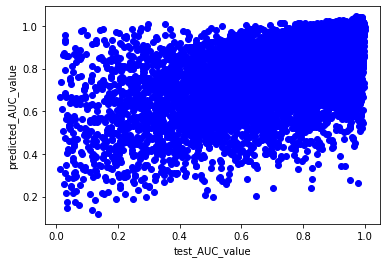

cnv data results:
0.7524475701865562 0.7440681069131201


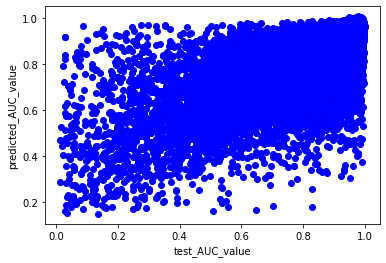

comb data results:
0.7146142321425091 0.7257672488652012


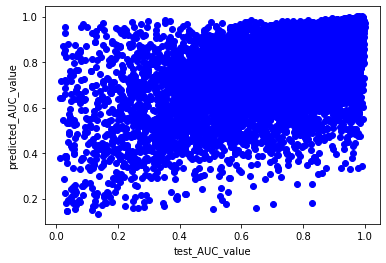

seg_cnv data results:
0.7473230712708816 0.73541866881633


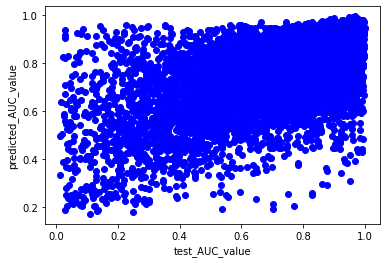

seg_comb data results:
0.7147230524492597 0.7264874834404651


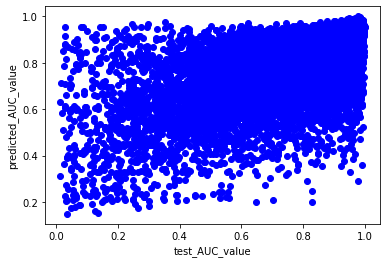

In [5]:
mapping_dict = {1:"mut",2:"cnv",3:"comb",4:"seg_cnv",5:"seg_comb"}
for i in range(1, 6):
    
    print(mapping_dict[i]+" data results:")
    # without sim
    results = pd.read_csv(f"Results_0308/Result_{i}/results_sim_df_20_epochs_seed42.csv", delimiter='\t')
    results = results.drop_duplicates().reset_index(drop = True)
    results = results.iloc[results[["y_true","y_cell","y_drug"]].drop_duplicates().index].reset_index(drop = True)
    print(pearsonr(results.y_true, results.y_pred)[0], spearmanr(results.y_true, results.y_pred)[0])

    plt.figure()
    plt.scatter(results.y_true,results.y_pred,c='blue')
    plt.xlabel('test_AUC_value')
    plt.ylabel('predicted_AUC_value')
    plt.show()